# **MARKET BASKET ANALYSIS ON IMBD DATASET**
## Algorithms for Massive Datasets Project

In this project we will implement A-priori and FP-growth algorithms to in order to find frequent itemsets. In this case, we used the kaggle [IMDB Dataset](https://www.kaggle.com/ashirwadsangwan/imdb-dataset), in which we considered movies as baskets and actors as items.

----

Summary:

1.   Imports
2.   Pre-Processing
3.   Market Basket Analysis









## **1. Imports**

Importing kaggle.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinaviggiano","key":"53a50dae23b35b3c81b9063b6c417e93"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing imdb-dataset data.

In [1]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

imdb-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## **2. Pre-processing**

We will consider movies as baskets and actors as items.


In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import pandas as pd
import pickle

In [4]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [5]:
title_basics = spark.read.csv('title.basics.tsv.gz', header=True, sep = '\t')

In [6]:
title_basics = title_basics.filter((title_basics.titleType == 'movie'))
title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

In [7]:
title_basics_fraction = title_basics.sample(fraction=0.1, withReplacement=False, seed = 1)

In [8]:
title_principals = spark.read.csv('title.principals.tsv.gz', header=True, sep = '\t')

In [9]:
title_principals = title_principals.filter((title_principals.category == "actor") | (title_principals.category == "actress"))
title_principals = title_principals.select("tconst","nconst")
title_principals.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000005|nm0443482|
|tt0000005|nm0653042|
|tt0000007|nm0179163|
|tt0000007|nm0183947|
|tt0000008|nm0653028|
+---------+---------+
only showing top 5 rows



In [10]:
df_title = title_principals.join(title_basics, ["tconst"], 'leftsemi')
df_title_fraction = title_principals.join(title_basics_fraction, ["tconst"], 'leftsemi')
df_title.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt0000335|nm1010955|
|tt0000335|nm1012612|
|tt0000335|nm1011210|
|tt0000335|nm1012621|
|tt0000335|nm0675239|
+---------+---------+
only showing top 5 rows



In [10]:
name_basics = spark.read.csv('name.basics.tsv.gz', header=True, sep = '\t')

In [11]:
# Number of rows (movies) in the entire dataset
df_title.count()

1694722

In [12]:
# Number of rows (movies) in the dataset fraction 0.1
df_title_fraction.count()  # seed 24 = 168642

169199

In case we wanted to displey the actual name of the actor/actress instead of the ID, we can run the following cells.

In [ ]:
name_basics = name_basics.select("nconst","primaryName")

In [ ]:
df_actors_names = df_title.join(name_basics, ["nconst"], 'left')

In [ ]:
df_actors_names = df_actors_names.select("tconst","primaryName")

In [ ]:
baskets_names = df_actors_names.groupBy('tconst').agg(collect_set('primaryName').alias('actors'))
baskets_names.createOrReplaceTempView('baskets_')
df_actors_names.show(5)
baskets_names.show(5)

+---------+-----------------+
|   tconst|      primaryName|
+---------+-----------------+
|tt0000009|  Blanche Bayliss|
|tt0000502|      El Mochuelo|
|tt0000615|       Jim Gerald|
|tt0000679|    L. Frank Baum|
|tt0000009|William Courtenay|
+---------+-----------------+
only showing top 5 rows

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0000335|[John Jones, Mr. ...|
|tt0000502|[Antonio del Pozo...|
|tt0000630|[Fernanda Negri P...|
|tt0000676|[Jaime Borrás, Jo...|
|tt0000793|      [Henny Porten]|
+---------+--------------------+
only showing top 5 rows



## **3. Market Basket Analysis**

We define and populate baskets: for each movie (*tconst*) we assign the list of actors (*nconst*) preforming in it.

In [11]:
from pyspark.sql.functions import collect_set, col, count, avg
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import time
from tqdm import tqdm

In [12]:
# Computed on the whole df
baskets = df_title.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets.createOrReplaceTempView('baskets')
#baskets.show(5)

In [13]:
# Computed on 0.1 fraction
baskets_fraction = df_title_fraction.groupBy('tconst').agg(collect_set('nconst').alias('actors'))
baskets_fraction.createOrReplaceTempView('baskets_fraction')
#baskets_fraction.show(5)

### **3.2 A-priori Algorithm**
We implement an A-priori Algorithm from scratch.

The function takes as input a Resilient Distributed Dataset (RDD) and a given threshold:

*   We created a list of lists composed of each itemset and we flattened it.
*   We created tuples associating to each item its frequency count.
*   We filtered the singletons based on the threshold chosen and we kept only items with frequency above the level provided.
*   We built all the possible combinations of pairs of frequent singletons retrieved in the previous step: we checked if each pair we retrieved were present in out set of baskets and then we filtered again for the threshold.
*   We repeated the steps above to search for frequent triplets, starting from the results we obtained previously.

At the end of the process we obtained a list of tuples of frequent itemsets and the corresponding frequency.

In [14]:
conf = SparkConf().setAppName("MBA")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [15]:
import itertools
from itertools import combinations, product
import pandas as pd
import matplotlib.pyplot as plt
import collections
import time
import pickle

First of all, we create a Resilient Distributed Dataset RDD, which corresponds to the list of baskets of actors.

In [16]:
# Computed on the whole dataset
baskets_actors = baskets.select('actors').rdd.flatMap(list) 
print(baskets_actors.collect()[:3])

[['nm1012612', 'nm0675260', 'nm1012621', 'nm1010955', 'nm0675239', 'nm1011210'], ['nm0624446'], ['nm0140054', 'nm0097421']]


In [17]:
baskets_actors.getNumPartitions() 

4

In [16]:
# Computed on the fraction 0.1
baskets_actors_fraction = baskets_fraction.select('actors').rdd.flatMap(list) 
print(baskets_actors_fraction.collect()[:3])

[['nm0252720', 'nm0215752'], ['nm0167461', 'nm0941542', 'nm0756543', 'nm0154988'], ['nm0898366']]


In [17]:
baskets_actors_fraction.getNumPartitions() 

2

 We first define a function listing all the actors/actresses present in dataset and counting occurrences.

In [18]:
def count_singletons(data): 
  list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
  return(list_singletons)

We display the top 10 actors present in our dataset with respect to the occurrencies.

In [ ]:
freq_actors = count_singletons(baskets_actors).sortBy(lambda a: -a[1])
freq_actors.take(10)

[('nm0103977', 797),
 ('nm0006982', 585),
 ('nm0648803', 565),
 ('nm0305182', 506),
 ('nm0623427', 436),
 ('nm0793813', 411),
 ('nm0246703', 391),
 ('nm0619107', 387),
 ('nm0007123', 380),
 ('nm7390393', 356)]

We then define a function filtering out singletons (actors) not compliant with the threshold we chose.

In [19]:
def actors_threshold(baskets, threshold, remove=True):
    actors_selected = count_singletons(baskets).filter(lambda freq: freq[-1] >= threshold)
    if removed:
        actors_selected = actors_selected.map(lambda a: (a[:-1])) #(a[0])
    return (actors_selected)

In [ ]:
# Testing 
t1 = actors_threshold(baskets_actors, 118)

In [ ]:
t1.take(2)

['nm0435229', 'nm0002503']

We define a function which performs the computations of both the functions above: *count_singletons* and *actors_threshold*.

In [20]:
def singleton_threshold(data, threshold):
    list_singletons = data.flatMap(list).map(lambda actor: (actor, 1)).reduceByKey(lambda a, b: a+b)
    actors_counts = list_singletons.filter(lambda freq: freq[1] >= threshold)
    actors_selected = actors_counts.map(lambda a: (a[0]))
    return(actors_selected)

In [ ]:
# Testing
t2 = singleton_threshold(baskets_actors, 118)

In [ ]:
t2.take(2)

['nm0435229', 'nm0002503']

We set the threshold we will use in the Apriori algorithm.

In [21]:
count_fraction = baskets_actors_fraction.count()
threshold_fraction = count_fraction*0.0005
print(count_fraction, threshold_fraction)

38991 19.4955


In [22]:
threshold_fraction = count_fraction*0.0003

In [25]:
count = baskets_actors.count()
threshold = count*0.0003
print(count, threshold)

393759 118.12769999999999


We define the Apriori algorithm.

In [23]:
def Apriori(baskets, threshold):

    # SINGLETONS
    # retrieve list of singletons (actors) with frequence above the threshold in data
    singletons = singleton_threshold(baskets, threshold)

    # PAIRS
    # compute all possible combinations of 2 elements (pairs) from le list of frequent items "singletons"
    comb_actors = list(combinations(singletons.toLocalIterator(), 2))
    # create empty list
    selected = sc.parallelize([]) 
    # select only frequent pairs, i.e. with frequence above the threshold
    frequent_items_1 = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
    # populate the list with frequent pairs   
    selected = selected.union(frequent_items_1) 

    # TRIPLETS
    # pre-process sets
    pairs = frequent_items_1.map(lambda item: list(item[0]))
    sin = count_singletons(singletons).map(lambda item: [item[0]])
    # create empty list for new combinations
    comb_actors = [] 
    # build combinations of three elements (triplets) between the pairs filtered for threshold and singletons filtered for threshold
    for x in list(product(pairs.toLocalIterator(), sin.toLocalIterator())): 
        combination = x[0]+x[1] 
        comb_actors.append(combination)
    # select only frequent triplets, i.e. with frequence above the threshold
    frequent_items_2 = baskets.flatMap(lambda basket: [(tuple(item), 1) for item in comb_actors if set(list(item)).issubset(set(basket))]).reduceByKey(lambda a, b: a+b).filter(lambda freq: freq[1] >= threshold)
    # populate the list with frequent triplets     
    selected = selected.union(frequent_items_2) 

    return(selected)



We train model on the fraction of the dataset.

In [ ]:
# 0.0003 (4675.24 sec) 1h 20min
# 0.0004 (1083.38 sec) 18 min
# 0.0005 (731.96 sec) 3 min
start_time = time.time()
priori_frac_0003 = Apriori(baskets_actors_fraction, threshold_fraction).collect()
print(time.time() - start_time)
time_frac_0003 = time.time() - start_time

We display the results of the three models below.

In [ ]:
priori_frac_0003

In [32]:
priori_frac_0003

[(('nm0619779', 'nm0006982'), 16),
 (('nm0619779', 'nm0623427'), 15),
 (('nm0006982', 'nm0623427'), 30),
 (('nm0006982', 'nm0046850'), 21),
 (('nm0006982', 'nm0419653'), 19),
 (('nm0046850', 'nm0419653'), 16),
 (('nm0623427', 'nm0419653'), 14),
 (('nm0616102', 'nm0006982'), 13),
 (('nm2366585', 'nm2384746'), 12),
 (('nm2082516', 'nm0648803'), 15)]

In [24]:
priori_frac_0004 #0.2

[(('nm0006982', 'nm0623427'), 50),
 (('nm0006982', 'nm0419653'), 47),
 (('nm0006982', 'nm0046850'), 37),
 (('nm0648803', 'nm2373718'), 34),
 (('nm2082516', 'nm2077739'), 32),
 (('nm2082516', 'nm0648803'), 40),
 (('nm2082516', 'nm2373718'), 33),
 (('nm2077739', 'nm0648803'), 33)]

In [28]:
priori_frac_0005 #0.2

[(('nm0006982', 'nm0623427'), 46)]

In [29]:
priori_frac_0005 #0.2

[(('nm0006982', 'nm0623427'), 53)]

In [33]:
priori_frac_0005

[(('nm0623427', 'nm0006982'), 23),
 (('nm0006982', 'nm0419653'), 27),
 (('nm0006982', 'nm0046850'), 21)]

In [33]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/priori_frac_0003.pkl", "wb") as f:
    pickle.dump(priori_frac_0003, f)

In [34]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/time_frac_0003.pkl", "wb") as f:
    pickle.dump(time_frac_0003, f)

In [29]:
time = ['4675', '1083', '731']
support = ['0.0003', '0.0004', '0.0005']
d = {'Support':support, 'Seconds':time}
df_models_frac = pd.DataFrame(d)
df_models_frac

In [ ]:
plot_time_frac = df_models_frac.plot(x="Support", y="Seconds", ylabel='Seconds', legend=False, title='Seconds spent in computation per support value', ylim=(500,5000), rot=0)

In [25]:
df_priori_frac_0003 = pd.DataFrame(priori_frac_0003, columns=['Actors', 'Frequency'])
df_priori_frac_0004 = pd.DataFrame(priori_frac_0004, columns=['Actors', 'Frequency'])
df_priori_frac_0005 = pd.DataFrame(priori_frac_0005, columns=['Actors', 'Frequency'])

In [36]:
df_priori_frac_0003.to_csv('df_priori_frac_0003.csv')
df_priori_frac_0004.to_csv('df_priori_frac_0004.csv')
df_priori_frac_0005.to_csv('df_priori_frac_0005.csv')

In [ ]:
!cp df_priori_frac_0003.csv /content/drive/MyDrive/Università/amd_Market_Basket/

In [ ]:
!cp df_priori_frac_0004.csv /content/drive/MyDrive/Università/amd_Market_Basket/

In [37]:
!cp df_priori_frac_0005.csv /content/drive/MyDrive/Università/amd_Market_Basket/

---

In [35]:
# 0.0003 () > 1 ora
# 0.0004 (4317.18 sec) 1 ora 10min
# 0.0005 (1198.61 sec) 20 min
start_time = time.time()
priori_0003 = Apriori(baskets_actors, threshold).collect() # 0.0003 20 min
print(time.time() - start_time)
time_0003 = time.time() - start_time

KeyboardInterrupt: ignored

We display the results of the three models below.

In [ ]:
priori_0003

In [38]:
priori_0004

[(('nm0006982', 'nm0623427'), 236),
 (('nm0006982', 'nm0419653'), 162),
 (('nm0006982', 'nm0046850'), 169)]

In [38]:
priori_0005

[(('nm0006982', 'nm0623427'), 236)]

In [41]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/priori_0003.pkl", "wb") as f:
    pickle.dump(priori_0003, f)

In [42]:
with open("/content/drive/MyDrive/Università/amd_Market_Basket/time_0003.pkl", "wb") as f:
    pickle.dump(time_0003, f)

In [ ]:
df_priori_frac_0003 = pd.DataFrame(priori_frac_0003, columns=['Actors', 'Frequency'])
df_priori_frac_0004 = pd.DataFrame(priori_frac_0004, columns=['Actors', 'Frequency'])
df_priori_frac_0005 = pd.DataFrame(priori_frac_0005, columns=['Actors', 'Frequency'])

---

---

### **3.1 FP-Growth**
In this section we will implement the FP-Growth algorithm by using the *FPGrowth* function of Spark.

First we will run it using different values of support to see the differences in terms of time spent in computation and average confidence.

In [13]:
seconds = []
confidences = []
n_rules = []
supports = [0.00001, 0.00002, 0.00003, 0.00004, 0.0001]

for sup in tqdm(supports):
    fpGrowth = FPGrowth(itemsCol="actors", minSupport=sup)
    start_time = time.time()
    model_ = fpGrowth.fit(baskets)
    seconds.append([sup, time.time() - start_time])
    associationRules_ = model_.associationRules
    rules = associationRules_.count()
    n_rules.append([sup, rules])
    conf = associationRules_.select(avg(col("confidence"))).first()[0]
    confidences.append([sup, conf])

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning
100%|██████████| 5/5 [14:13<00:00, 170.61s/it]


We plot the relation between value of support and time spent in computing.

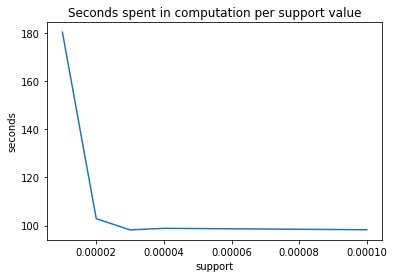

In [27]:
df_results = pd.DataFrame(seconds, columns=["support", "seconds"])
plot_time = df_results.plot(x="support", y="seconds", ylabel='seconds',legend=False, title='Seconds spent in computation per support value')
df_results.to_csv("time_results_fpgrowth.csv", index=False)

In [28]:
plot_time = plot_time.get_figure()
plot_time.savefig("/content/drive/MyDrive/Università/amd_Market_Basket/plot_time.png")

In [29]:
df_results

,support,seconds
0,0.00001,180.346866
1,0.00002,102.854542
2,0.00003,98.167766
3,0.00004,98.828109
4,0.00010,98.243761


In [30]:
!cp time_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

We plot the relation between value of support and average value of confidence retrieved.

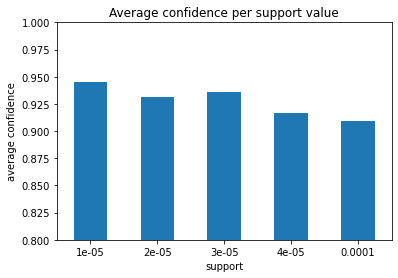

In [58]:
df_avgconf = pd.DataFrame(confidences, columns=["support", "average_confidence"])
plot_confidence = df_avgconf.plot.bar(x="support", y="average_confidence", ylabel='average confidence', legend=False, title='Average confidence per support value', ylim=(0.8,1), rot=0)
df_avgconf.to_csv("avgconficence_results_fpgrowth.csv", index=False)

In [59]:
plot_confidence = plot_confidence.get_figure()
plot_confidence.savefig("/content/drive/MyDrive/Università/amd_Market_Basket/plot_confidence.png")

In [60]:
df_avgconf

,support,average_confidence
0,0.00001,0.945333
1,0.00002,0.931293
2,0.00003,0.936198
3,0.00004,0.916267
4,0.00010,0.909584


In [61]:
!cp avgconficence_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

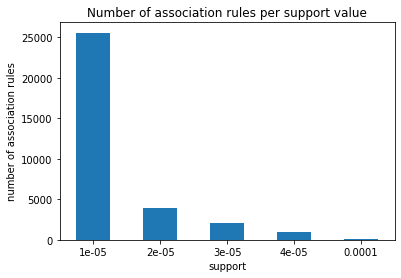

In [62]:
df_nrules = pd.DataFrame(n_rules, columns=["support", "n_rules"])
plot_nrules = df_nrules.plot.bar(x="support", y="n_rules", ylabel='number of association rules', legend=False, title='Number of association rules per support value', rot=0)
df_nrules.to_csv("nrules_results_fpgrowth.csv", index=False)

In [63]:
plot_nrules = plot_nrules.get_figure()
plot_nrules.savefig("/content/drive/MyDrive/Università/amd_Market_Basket/plot_nrules.png")

In [37]:
df_nrules

,support,n_rules
0,0.00001,25583
1,0.00002,3893
2,0.00003,2051
3,0.00004,940
4,0.00010,120


In [38]:
!cp nrules_results_fpgrowth.csv /content/drive/MyDrive/Università/amd_Market_Basket/

In the following part we selected support value 0.00001 and we display the results of the model.

In [ ]:
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.00001)
model = fpGrowth.fit(baskets)

We Display association rules generated by the model computed setting the support equal to 0.00001

In [ ]:
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----------+------------------+------------------+--------------------+
|          antecedent| consequent|        confidence|              lift|             support|
+--------------------+-----------+------------------+------------------+--------------------+
|         [nm3721804]|[nm1990182]|               0.8|3841.5512195121955|1.015849796449097E-5|
|         [nm3721804]|[nm1984183]|               1.0|2250.0514285714285|1.269812245561371...|
|[nm0623325, nm381...|[nm0706691]|0.8571428571428571|1071.4530612244896|1.523774694673645...|
|[nm2719915, nm128...|[nm1770187]|0.8571428571428571|2836.1992797118846|1.523774694673645...|
|[nm2719915, nm128...|[nm2077739]|0.8571428571428571|2884.6813186813188|1.523774694673645...|
|[nm2719915, nm128...|[nm0648803]|               1.0| 696.9185840707964| 1.77773714378592E-5|
|[nm1371510, nm075...|[nm1285427]|               0.8|3461.6175824175825|1.015849796449097E-5|
|[nm0931054, nm041...|[nm0001889]|               0.8|       

In [ ]:
associationRules.select(avg(col("confidence"))).show()

+------------------+
|   avg(confidence)|
+------------------+
|0.9453328386316634|
+------------------+

